# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from datetime import datetime

# SKlearn 
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,accuracy_score
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

# Read Incidents Dataset - Capstone I 
incidents = pd.read_csv('../data/Aggregated/incidents.csv')
incidents.columns

Index(['Incident ID', 'Incident Date', 'Incident Time', 'Day',
       'Incident County Name', 'Incident State', 'Victim ID', 'Gender Desc',
       'Age Range', 'Race', 'Ethnicity Desc', 'Naloxone Administered',
       'Survive', 'Response Desc', 'All Drugs', 'Incident Date ym'],
      dtype='object')

In [3]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Pre-processing

## Multi-drug use

In [5]:
incidents['Multiple Drugs'] = 0
incidents.loc[incidents['All Drugs'].str.contains(' | ', regex = False), 'Multiple Drugs'] = 1
incidents[incidents['Multiple Drugs'] == 1].shape

(8050, 17)

## Fentanyl

In [6]:
incidents['Fentanyl'] = 0
incidents.loc[incidents['All Drugs'].str.contains('FENTANYL', regex = False), 'Fentanyl'] = 1
incidents['Fentanyl'].value_counts()

0    13342
1     7255
Name: Fentanyl, dtype: int64

## Year, Month and Age Range

In [7]:
def agerange_weekend(df):
    
    df_cpy = df.copy()
    for i, row in df_cpy.iterrows():
        
        # Weekend Binary Feature
        if row['Day'] in ['Friday', "Saturday", "Sunday"]:
            df_cpy.loc[i,'Weekend_OD'] = 1
        else:
            df_cpy.loc[i,'Weekend_OD'] = 0
        
        # Season Features - Winter, Spring, Summer and Fall
        if row['month'] in [1, 12, 2]:
            df_cpy.loc[i,'Season'] = 'Winter'
            
        elif row['month'] in [3,4, 5]:
            df_cpy.loc[i,'Season'] = 'Spring'
            
        elif row['month'] in [6, 7, 8]:
            df_cpy.loc[i,'Season'] = 'Summer'
            
        elif row['month'] in [9, 10, 11]:
            df_cpy.loc[i,'Season'] = 'Fall' 
        
        # Age Binary feature - over/below 40 years old
        if row['Age Range'] in ['0 - 9', '10 - 14', '15 - 19', '20 - 24','25 - 29', '30 - 39']:
            df_cpy.loc[i,'Over 40'] = 0
        else:    
            df_cpy.loc[i,'Over 40'] = 1
        
    # Ensure dtype for binary features is int
    df_cpy['Over 40'] = df_cpy['Over 40'].astype(int)
    df_cpy['Weekend_OD'] = df_cpy['Weekend_OD'].astype(int)
        
    return df_cpy

In [8]:
incidents["year"] = incidents['Incident Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').year)
incidents["month"] = incidents['Incident Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').month)

# Fix value typo
incidents["Age Range"] = incidents["Age Range"].apply(lambda x: "10 - 14" if x == "14-Oct" else x)

# Sanity Check
incidents['Age Range'].value_counts()

30 - 39    7653
25 - 29    4082
40 - 49    3434
20 - 24    2030
50 - 59    1871
60 - 69     634
0 - 9       530
15 - 19     276
70 - 79      70
80 - *       10
10 - 14       7
Name: Age Range, dtype: int64

In [24]:
incidents2 = agerange_weekend(incidents)
incidents2.head(2)

,Incident ID,Incident Date,Incident Time,Day,Incident County Name,Incident State,Victim ID,Gender Desc,Age Range,Race,...,Response Desc,All Drugs,Incident Date ym,Multiple Drugs,Fentanyl,year,month,Weekend_OD,Season,Over 40
0,1,1/4/2018,0:42:00,Thursday,Delaware,Pennsylvania,1,Male,50 - 59,White,...,NO RESPONSE TO NALOXONE,COCAINE/CRACK | HEROIN,2018,1,0,2018,1,0,Winter,1
1,26,1/26/2018,9:14:00,Friday,Chester,Pennsylvania,5,Male,25 - 29,White,...,None,HEROIN,2018,0,0,2018,1,1,Winter,0


In [25]:
df2 = incidents2[['Day','Incident County Name','Gender Desc','Age Range','Race','Naloxone Administered','Survive','Multiple Drugs','Fentanyl',
                  'year','month','Weekend_OD','Season','Over 40']]

In [27]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
import matplotlib.pyplot as plt

numeric_cols = df2.select_dtypes(include=['float', 'int']).columns
string_cols = df2.select_dtypes(include=['object']).columns

df2 = pd.get_dummies(df2, columns=string_cols)

In [28]:
selector = SelectKBest(score_func=f_classif, k=10)
X = df2.drop('Survive', axis=1)  # remove the target column
y = df2['Survive']
X_selected = selector.fit_transform(X, y)

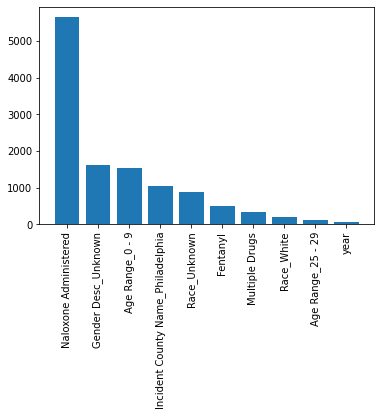

In [29]:
scores = selector.scores_
feature_names = X.columns
sorted_indices = scores.argsort()[::-1][:10]  # get the top 10 feature indices
plt.bar(range(10), scores[sorted_indices])
plt.xticks(range(10), feature_names[sorted_indices], rotation=90)
plt.show()

In [42]:
#### Coorlation
corr = X.corrwith(y)


In [46]:
corr_df = pd.DataFrame({'feature':corr.index, 'correlation':corr.values})
corr_df = corr_df.sort_values(by=['correlation'], ascending=False)


In [47]:
corr_df

,feature,correlation
5,Naloxone Administered,0.463989
3,Age Range,0.068231
4,Race,0.037154
11,Season,0.015148
10,Weekend_OD,0.004335
0,Day,-0.020460
9,month,-0.023816
1,Incident County Name,-0.049350
12,Over 40,-0.054193
8,year,-0.056942


In [31]:
X.columns

Index(['Naloxone Administered', 'Multiple Drugs', 'Fentanyl', 'year', 'month',
       'Weekend_OD', 'Over 40', 'Day_Friday', 'Day_Monday', 'Day_Saturday',
       ...
       'Age Range_80 - *', 'Race_American Indian or Alaskan Native',
       'Race_Asian or Pacific Islander', 'Race_Black', 'Race_Unknown',
       'Race_White', 'Season_Fall', 'Season_Spring', 'Season_Summer',
       'Season_Winter'],
      dtype='object', length=103)

In [34]:
df3 = incidents2[['Day','Incident County Name','Gender Desc','Age Range','Race','Naloxone Administered','Survive','Multiple Drugs','Fentanyl',
                  'year','month','Weekend_OD','Season','Over 40']]

In [33]:
from sklearn.preprocessing import LabelEncoder

def label_encode_strings(df):
    """
    Label encodes all the string columns in a pandas DataFrame.
    
    Args:
        df (pandas.DataFrame): The DataFrame to label encode.
    
    Returns:
        pandas.DataFrame: The label encoded DataFrame.
    """
    # Create a new DataFrame to hold the label encoded data
    encoded_df = df.copy()

    # Loop over all columns in the DataFrame
    for col in encoded_df.columns:
        if encoded_df[col].dtype == "object":
            # If the column contains strings, use LabelEncoder to encode them
            le = LabelEncoder()
            encoded_df[col] = le.fit_transform(encoded_df[col].astype(str))
    
    return encoded_df
 



In [35]:
df4 = label_encode_strings(df3)

In [36]:
### Recursive feature elemination


selector = SelectKBest(score_func=f_classif, k=10)
X = df4.drop('Survive', axis=1)  # remove the target column
y = df4['Survive']
X_selected = selector.fit_transform(X, y)



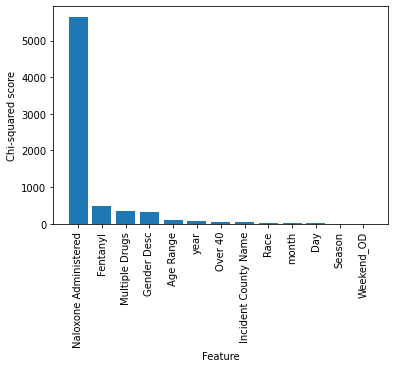

In [39]:
import matplotlib.pyplot as plt
import numpy as np

scores = selector.scores_
features = X.columns
sorted_indices = np.argsort(scores)[::-1]  # Descending order
sorted_scores = scores[sorted_indices]
sorted_features = [features[i] for i in sorted_indices]

plt.bar(range(len(features)), sorted_scores)
plt.xticks(range(len(features)), sorted_features, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Chi-squared score')
plt.show()






In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
import matplotlib.pyplot as plt

# load the dataframe (replace 'dataframe.csv' with the actual filename)
df = pd.read_csv('dataframe.csv')

# separate the numerical and string columns
numeric_cols = df.select_dtypes(include=['float', 'int']).columns
string_cols = df.select_dtypes(include=['object']).columns

# convert the string columns to numerical using one-hot encoding
df = pd.get_dummies(df, columns=string_cols)

# apply feature selection using SelectKBest with f_classif score function
selector = SelectKBest(score_func=f_classif, k=10)
X = df.drop('target', axis=1)  # remove the target column
y = df['target']
X_selected = selector.fit_transform(X, y)

# plot the scores of the top 10 features
scores = selector.scores_
feature_names = X.columns
sorted_indices = scores.argsort()[::-1][:10]  # get the top 10 feature indices
plt.bar(range(10), scores[sorted_indices])
plt.xticks(range(10), feature_names[sorted_indices], rotation=90)
plt.show()
In this example, the code first separates the numerical and string columns using the select_dtypes method, and then converts the string columns to numerical using one-hot encoding using the get_dummies method. The SelectKBest class is then used to apply feature selection using the f_classif score function, which is appropriate for classification problems. The k parameter is set to 10 to select the top 10 features. Finally, the scores of the top 10 features are plotted using a bar chart. Note that the target column is assumed to be the target variable that you are trying to predict, so it is removed from the feature matrix before applying feature selection.




Regenerate response

In [7]:
#### Good

X = incidents2[['Over 40','Naloxone Administered','Fentanyl','Multiple Drugs']]
y = incidents2[['Survive']]

# Class weights are required because of class imbalance issue
class_weight_m = dict(y['Survive'].value_counts())
class_weight_m

{1: 15492, 0: 5105}

## Pipeline Definition

In [8]:
##pipeline  NOT GOOD

#label_features =['Season']
#label_transformer = OneHotEncoder(sparse = False, handle_unknown = 'ignore')



#preprocessor = ColumnTransformer(
    #transformers=[
        #('label', label_transformer, label_features)
        #])   


#model =  Pipeline(steps=[('preprocessor', preprocessor),
                     # ('randomforest', RandomForestClassifier(n_estimators=1000,
                      #                                        class_weight=class_weight_m))])

In [9]:
#### Good

# Random Forest
rf_model =  Pipeline(steps=[
                      ('randomforest', RandomForestClassifier(n_estimators=1000,
                                                              class_weight=class_weight_m))])

# Logistic regression
lr_model = Pipeline(steps=[
                           ('logisticregression', LogisticRegression(class_weight=class_weight_m))])

# Decision Tree
dt_model =  Pipeline(steps=[
                           ('decisiontree',DecisionTreeClassifier(random_state = 42,
                                                                  class_weight=class_weight_m))])

## Split data

In [10]:
# Split data with stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

## Class Imbalance

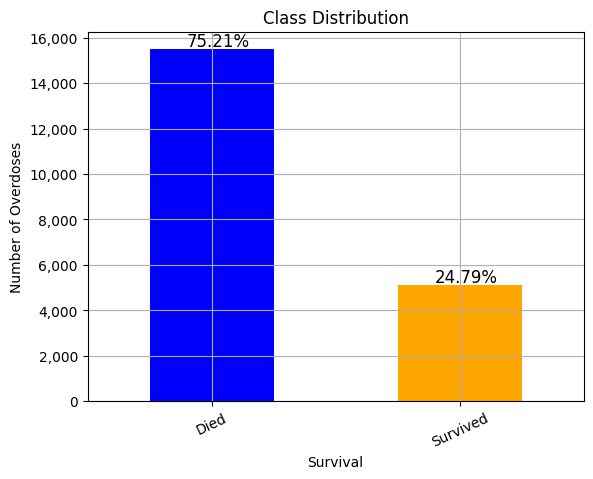

In [82]:
total_od = sum(y.value_counts())
ax = y.value_counts().plot(kind="bar",
                           rot = 25,
                           title = "Class Distribution",
                           ylabel = "Number of Overdoses",
                           xlabel = "Survival",
                           grid = True,
                           color = ["Blue", "Orange"])
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, _: format(int(x), ',')))
ax.set_xticklabels(["Died", "Survived"])

for patch in ax.patches:
    ax.annotate('{:.2f}%'.format(patch.get_height() / total_od * 100),                # Count
               (patch.get_x() + 0.15, patch.get_height()+150),          # x,y coordinates for label.
               fontsize=12)  

In [87]:
help(incidents2.corr)

Help on method corr in module pandas.core.frame:

corr(method: 'str | Callable[[np.ndarray, np.ndarray], float]' = 'pearson', min_periods: 'int' = 1, numeric_only: 'bool | lib.NoDefault' = <no_default>) -> 'DataFrame' method of pandas.core.frame.DataFrame instance
    Compute pairwise correlation of columns, excluding NA/null values.
    
    Parameters
    ----------
    method : {'pearson', 'kendall', 'spearman'} or callable
        Method of correlation:
    
        * pearson : standard correlation coefficient
        * kendall : Kendall Tau correlation coefficient
        * spearman : Spearman rank correlation
        * callable: callable with input two 1d ndarrays
            and returning a float. Note that the returned matrix from corr
            will have 1 along the diagonals and will be symmetric
            regardless of the callable's behavior.
    min_periods : int, optional
        Minimum number of observations required per pair of columns
        to have a valid resul

<AxesSubplot: title={'center': 'Spearman Correlation'}>

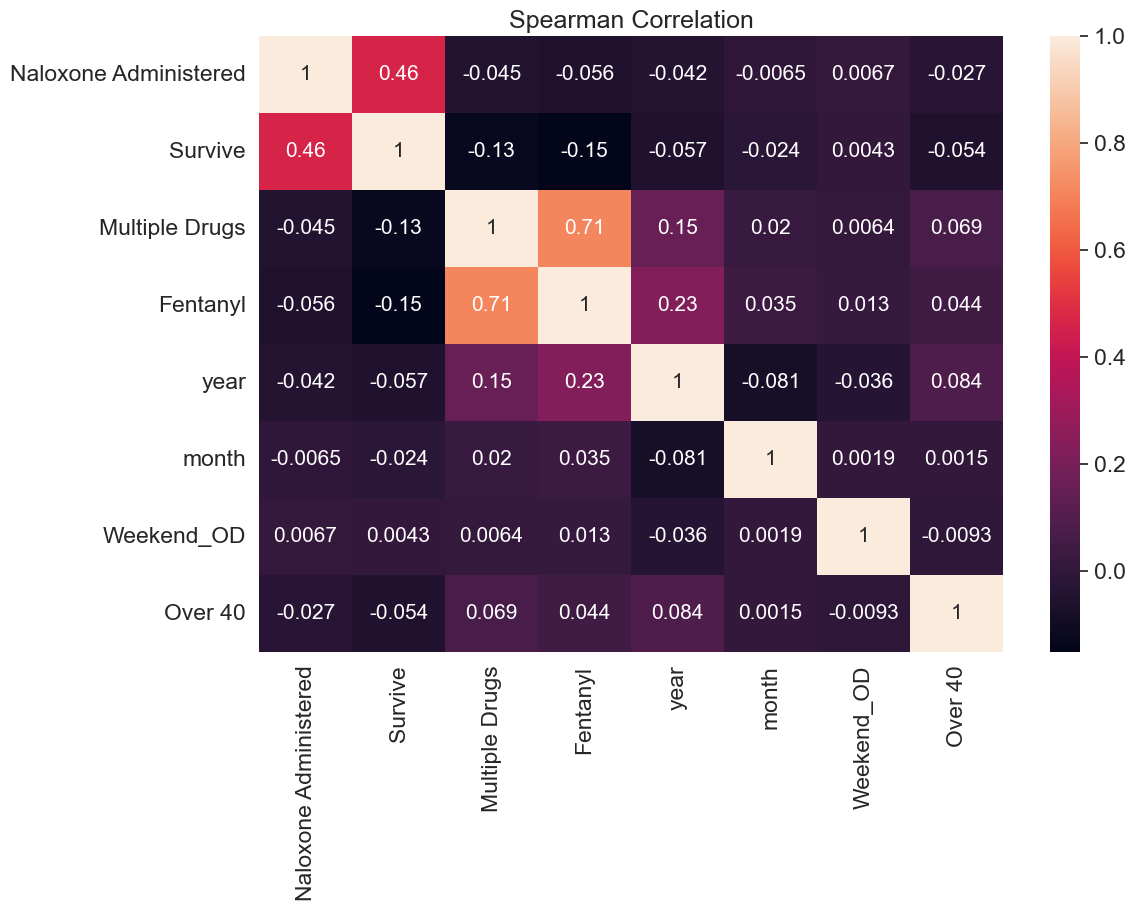

In [116]:
cor = incidents2.drop(['Incident ID', 'Victim ID', 'Incident Date ym'], axis = 1).corr(method = "spearman")
plt.figure(figsize = (12,8))
plt.title("Spearman Correlation")
sns.heatmap(cor, annot = True, cmap = 'rocket',annot_kws={"fontsize":15})

## Baseline

Dummy classifier predict survived (1) when Naloxone was administered AND there were no multiple drugs. Otherwise died.

In [11]:
dummy_clf = X_train[["Naloxone Administered", 'Multiple Drugs']].apply(lambda x: 1 if x[0] == 1 and x[1] == 0 else 0, axis = 1)
print(classification_report(y_train, dummy_clf, target_names=["Died", "Survived"]))

print(matthews_corrcoef(y_train,dummy_clf))

              precision    recall  f1-score   support

        Died       0.36      0.85      0.51      3829
    Survived       0.91      0.51      0.65     11618

    accuracy                           0.59     15447
   macro avg       0.64      0.68      0.58     15447
weighted avg       0.77      0.59      0.62     15447

0.3118325529188974


## Fit Models

In [12]:
# Random Forest
rf_model.fit(X_train,y_train)

Pipeline(steps=[('randomforest',
                 RandomForestClassifier(class_weight={0: 5105, 1: 15492},
                                        n_estimators=1000))])

In [13]:
# Logistic Regression
lr_model.fit(X_train,y_train)

Pipeline(steps=[('logisticregression',
                 LogisticRegression(class_weight={0: 5105, 1: 15492}))])

In [14]:
# Decision Tree
dt_model.fit(X_train,y_train)

Pipeline(steps=[('decisiontree',
                 DecisionTreeClassifier(class_weight={0: 5105, 1: 15492},
                                        random_state=42))])

## Predict

In [15]:
# Random Forest 
predictions_classweights = rf_model.predict(X_test)
print("accuracy:",accuracy_score(y_test, predictions_classweights))

accuracy: 0.777864077669903


In [16]:
# Logistic Regression
LR_predictions_classweights = lr_model.predict(X_test)
print("accuracy:",accuracy_score(y_test, LR_predictions_classweights))


accuracy: 0.7522330097087379


In [17]:
# Decision Tree
dt_predictions_classweights = dt_model.predict(X_test)
print("accuracy:",accuracy_score(y_test, dt_predictions_classweights))


accuracy: 0.777864077669903


# Cross Validation

In [18]:
def cross_validation(X, y, model, n_splits = 5,  **kwargs):
    
    # KFold object
    kf = StratifiedKFold(n_splits=n_splits,random_state=0, shuffle=True)
    
    # Empty lists
    acc_score = []
    pred = []
    y_test_all = []
    pred_prob = []
    
    # KFold iterations
    for i, (train_index, test_index) in enumerate(kf.split(X,y)):
        print(f"Run #{i}")
        
        # Train and test features and target
        X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
        
        # Fit and score model
        model.fit(X_train,y_train)
        print(model.score(X_test, y_test))
        num = model.score(X_test, y_test)
        num = num.astype(float)
        acc_score.append(num)
        
        # Predict
        predictions_classweights = model.predict(X_test)
        proba = model.predict_proba(X_test)
        pred_prob.append(proba)                           
        
        # Store results
        pred.append(predictions_classweights)
        y_test_all.append(y_test)
        
        # Print ROC AUC results
        print(f"ROC AUC Score: {roc_auc_score(y_test,predictions_classweights)}", end = "\n")
        
        print(f"Matthews Correlation: {matthews_corrcoef(y_test,predictions_classweights)}", end = "\n\n")
        
    # Return lists
    return pred, y_test_all, pred_prob


In [19]:
rf_cross_pred, rf_cross_test, rf_cross_prob = cross_validation(X, y, rf_model)

Run #0
0.7694174757281553
ROC AUC Score: 0.5465912829610133
Matthews Correlation: 0.21979231846357772

Run #1
0.7735436893203883
ROC AUC Score: 0.5578718167277112
Matthews Correlation: 0.24578335025642434

Run #2
0.7521243020150522
ROC AUC Score: 0.5
Matthews Correlation: 0.0

Run #3
0.7708181597475116
ROC AUC Score: 0.5531392405703595
Matthews Correlation: 0.23004473056258826

Run #4
0.7696042728817675
ROC AUC Score: 0.5500340177132382
Matthews Correlation: 0.22228411038795723



In [20]:
lr_cross_pred,lr_cross_test, lr_cross_prob = cross_validation(X, y, lr_model)

Run #0
0.7521844660194175
ROC AUC Score: 0.5
Matthews Correlation: 0.0

Run #1
0.7521844660194175
ROC AUC Score: 0.5
Matthews Correlation: 0.0

Run #2
0.7521243020150522
ROC AUC Score: 0.5
Matthews Correlation: 0.0

Run #3
0.7521243020150522
ROC AUC Score: 0.5
Matthews Correlation: 0.0

Run #4
0.7521243020150522
ROC AUC Score: 0.5
Matthews Correlation: 0.0



In [21]:
dt_cross_pred, dt_cross_test, dt_cross_prob= cross_validation(X, y, dt_model)

Run #0
0.7694174757281553
ROC AUC Score: 0.5465912829610133
Matthews Correlation: 0.21979231846357772

Run #1
0.7735436893203883
ROC AUC Score: 0.5578718167277112
Matthews Correlation: 0.24578335025642434

Run #2
0.7521243020150522
ROC AUC Score: 0.5
Matthews Correlation: 0.0

Run #3
0.7708181597475116
ROC AUC Score: 0.5531392405703595
Matthews Correlation: 0.23004473056258826

Run #4
0.7696042728817675
ROC AUC Score: 0.5500340177132382
Matthews Correlation: 0.22228411038795723



In [22]:
def change_threshold(pred_prob_all, y_test_all, threshold: int = .5):
    y_test_master = pd.concat(y_test_all)
    
    probs = [pd.DataFrame(a, columns = ['zero', 'one']) for a in pred_prob_all]
    probs_final = pd.concat(probs)
    probs_final = probs_final[['one']]
    
    probs_final['one'] = np.select([probs_final['one'] > threshold],  ### setting threshold
                                    [1],
                                    default=0)
    
    print("Confusion Matrix: ")
    print(confusion_matrix(y_test_master,probs_final), end = "\n\n")
    
     # Print ROC AUC results
    print(f"ROC AUC Score: {roc_auc_score(y_test_master,probs_final)}", end = "\n")
    print(f"Matthews Correlation: {matthews_corrcoef(y_test_master,probs_final)}", end = "\n\n")
    
    target_names = ['Died', 'Survived']
    print("Classification Report: ")
    print(classification_report(y_test_master, probs_final, target_names=target_names))
    
    
    
    return probs_final


In [23]:
change_threshold(rf_cross_prob, rf_cross_test, .8)

Confusion Matrix: 
[[ 3369  1736]
 [ 2729 12763]]

ROC AUC Score: 0.7418928995104864
Matthews Correlation: 0.45755362288364115

Classification Report: 
              precision    recall  f1-score   support

        Died       0.55      0.66      0.60      5105
    Survived       0.88      0.82      0.85     15492

    accuracy                           0.78     20597
   macro avg       0.72      0.74      0.73     20597
weighted avg       0.80      0.78      0.79     20597



,one
0,0
1,0
2,0
3,0
4,0
...,...
4114,1
4115,0
4116,1
4117,1


In [24]:
change_threshold(lr_cross_prob, lr_cross_test, .8)

Confusion Matrix: 
[[ 3511  1594]
 [ 2935 12557]]

ROC AUC Score: 0.7491522400870132
Matthews Correlation: 0.4639890090794525

Classification Report: 
              precision    recall  f1-score   support

        Died       0.54      0.69      0.61      5105
    Survived       0.89      0.81      0.85     15492

    accuracy                           0.78     20597
   macro avg       0.72      0.75      0.73     20597
weighted avg       0.80      0.78      0.79     20597



,one
0,0
1,0
2,0
3,0
4,0
...,...
4114,1
4115,0
4116,1
4117,1


In [25]:
change_threshold(dt_cross_prob, dt_cross_test, .8)

Confusion Matrix: 
[[ 3279  1826]
 [ 2638 12854]]

ROC AUC Score: 0.7360150118869604
Matthews Correlation: 0.45040938175931294

Classification Report: 
              precision    recall  f1-score   support

        Died       0.55      0.64      0.59      5105
    Survived       0.88      0.83      0.85     15492

    accuracy                           0.78     20597
   macro avg       0.71      0.74      0.72     20597
weighted avg       0.80      0.78      0.79     20597



,one
0,0
1,0
2,0
3,0
4,0
...,...
4114,1
4115,0
4116,1
4117,1


## ROC Plot

In [26]:
def plot_roc(pred_probs, y_test, threshold):
    # probs = [pd.DataFrame(a, columns = ['zero', 'one']) for a in pred_probs]
    # probs_final = pd.concat(probs)
    # probs_final = probs_final[['one']]
    probs_final = change_threshold(pred_probs, y_test, threshold = threshold)
    y_test_master = pd.concat(y_test)
    
    fpr, tpr, _ = roc_curve(y_test_master,probs_final)
    auc = roc_auc_score(y_test_master,probs_final)
    plt.figure(figsize=(10,10))
    plt.plot(fpr,tpr,label=" auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

Confusion Matrix: 
[[ 3369  1736]
 [ 2729 12763]]

ROC AUC Score: 0.7418928995104864
Matthews Correlation: 0.45755362288364115

Classification Report: 
              precision    recall  f1-score   support

        Died       0.55      0.66      0.60      5105
    Survived       0.88      0.82      0.85     15492

    accuracy                           0.78     20597
   macro avg       0.72      0.74      0.73     20597
weighted avg       0.80      0.78      0.79     20597



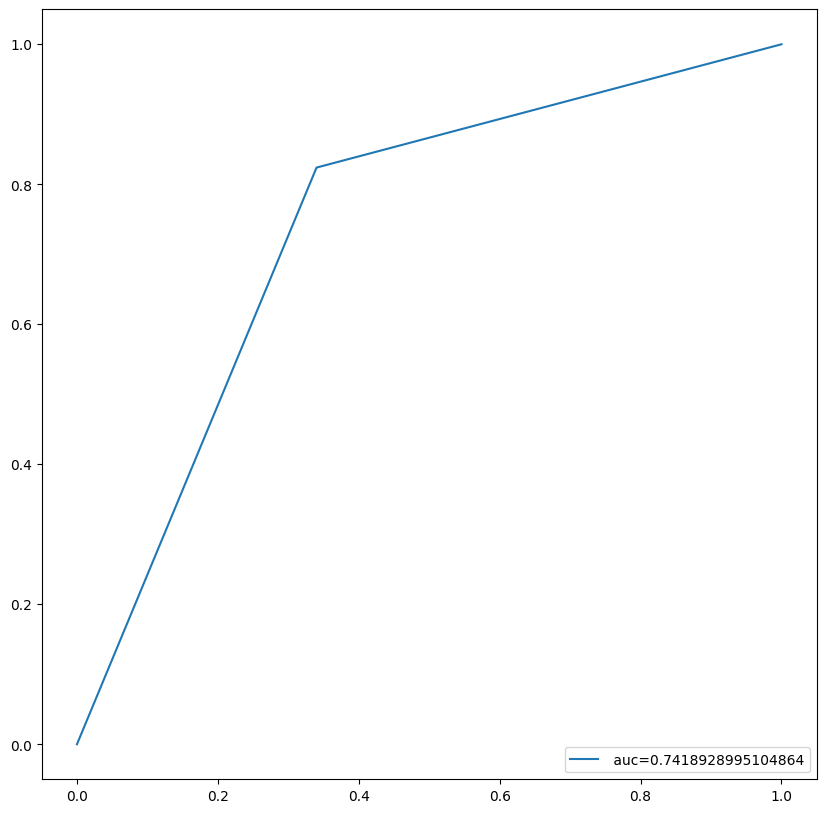

In [27]:
plot_roc(rf_cross_prob, rf_cross_test, 0.8)

# Feature Importance

In [28]:
# for gini importance
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

In [29]:
def row_to_dict(x,y=None):
    return X.apply(dict,axis=1)
    
def plot_importance(X, y, model, rot = 75, figsize = (20,5), kind = "bar"):
    ft = FunctionTransformer(row_to_dict, validate=False)
    dv = DictVectorizer()

    pipe = make_pipeline(ft,dv,model)
    pipe.fit(X,y)
    feature_importances = zip(dv.feature_names_,model[0].feature_importances_)
    
    feats = {}
    for feature, importance in zip(dv.feature_names_,feature_importances):
        feats[feature] = importance
        
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    importances.sort_values(by='Gini-importance').plot(kind=kind, rot=rot, figsize = figsize)

In [30]:
rf_model[0].feature_importances_

array([0.02359701, 0.8276904 , 0.10999189, 0.0387207 ])

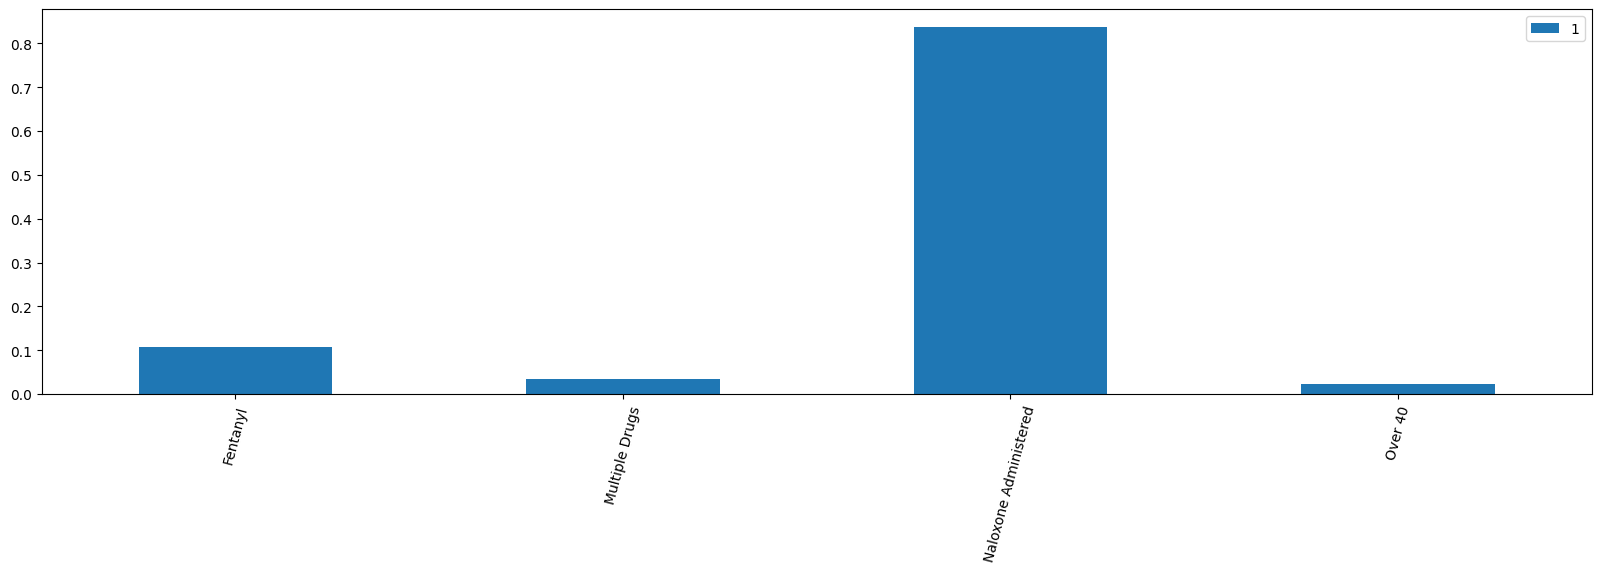

In [31]:
plot_importance(X, y, rf_model, rot = 75, figsize = (20,5))

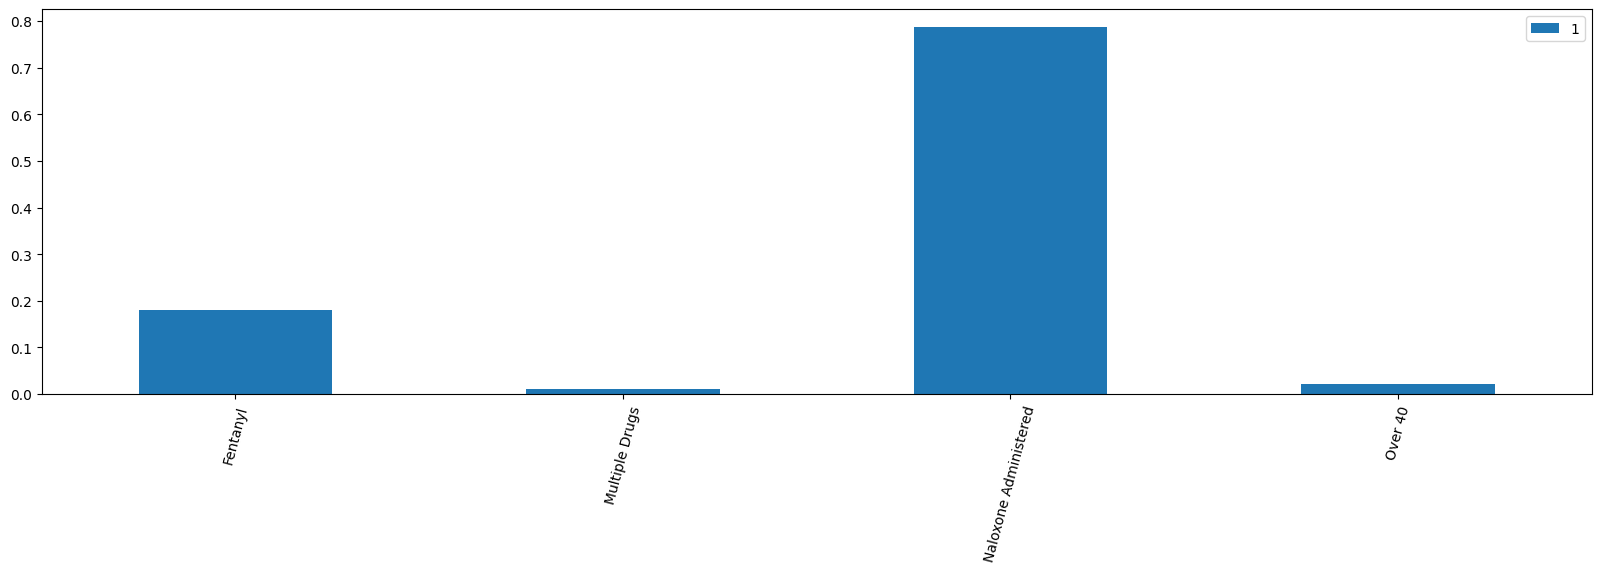

In [32]:
plot_importance(X, y, dt_model, rot = 75, figsize = (20,5))

# Conclusions
After changing threshold to around .8, both ROC and Matthews scores were increased. Recall our baseline results are:

Matthews: 0.312 <br>
ROC: 0.25 (Cross validation)

Higher threshold increased both scores to:<br>
Matthews: 0.45<br>
ROC: 0.736